Copy code
# ChemspaceSampler

- How many molecules can be found in chemical space as a function of representation distance (from a point in chemical space)?
- Does this number correlate with machine learning molecular properties?
- Is it possible to predict the density of molecules (in chemical space) around a query molecule? **SPOILER: YES it is!!!**
- I study this using Konstantin's MC code and will try to link the prediction error for a molecule to the number of molecules around a central molecule in chemical space (work in progress)

First example: 2D representation of molecules
- Use RDKit to generate 2D representations of molecules X_1, X_2
- Distance between two molecules defined as d = ||X_1 - X_2||_2

In [1]:
from rdkit import Chem
from mosaics.minimized_functions import chemspace_potentials
import numpy as np
from numpy.linalg import norm
import os, sys, io
from rdkit.Chem import Draw
import random
from tqdm import tqdm




random.seed(42)
np.random.seed(1337)

mol_ind = "testrun"
cwd = os.getcwd()
respath = f"{cwd}/results/hist/"

os.makedirs(respath, exist_ok=True)
nBits = 2048

[14:01:47] Enabling RDKit 2019.09.3 jupyter extensions
RDKit WARNING: [14:01:47] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
smiles_1, smiles_2 =  "CC(=O)OC1=CC=CC=C1C(=O)O", "CCCCC"

def initialize_from_smiles(SMILES):
    bits = 2048
    smiles_with_H = Chem.MolToSmiles(Chem.AddHs(Chem.MolFromSmiles(SMILES)))
    output =  SMILES_to_egc(smiles_with_H)
    rdkit_init = Chem.AddHs(Chem.MolFromSmiles(smiles_with_H))
    X_init = chemspace_potentials.get_all_FP([rdkit_init],fp_type="MorganFingerprint", nBits=bits) 

    return X_init,rdkit_init, output

X_1, rdkit_1, egc_1 = initialize_from_smiles(smiles_1)
X_2, rdkit_2, egc_2 = initialize_from_smiles(smiles_2)


d = norm(X_1 - X_2)
print(d)

6.6332495807108


Initial molecule looks like this, Konstantin called it the Alien molecule:

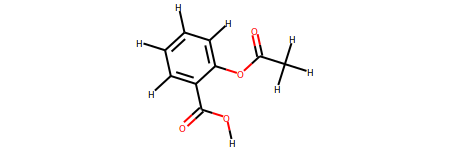

In [3]:
rdkit_1

Play with it! As you change the smiles string, the 2D representation of the molecule changes. By that you also increase or decrease the distance `d` between the molecules.

Next we define a potential that we will use to probe chemical space at a given target distance `d`. For the example given below we would be sampling molecules at distance between d=2 and d=4. The potential is defined as

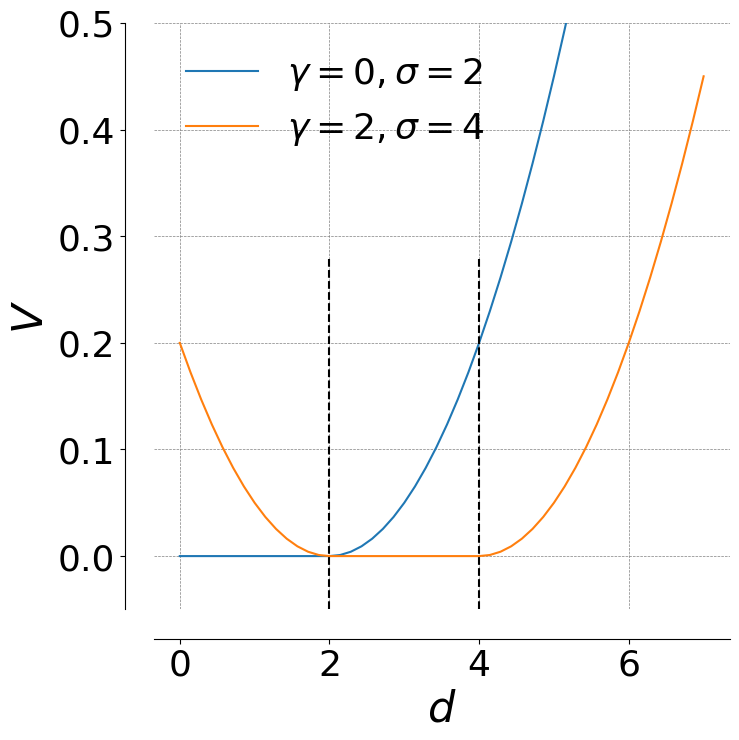

In [3]:
import matplotlib.pyplot as plt

fs = 26
plt.rc("font", size=fs)
plt.rc("axes", titlesize=fs)
plt.rc("axes", labelsize=fs)
plt.rc("xtick", labelsize=fs)
plt.rc("ytick", labelsize=fs)
plt.rc("legend", fontsize=fs)
plt.rc("figure", titlesize=fs)

def make_pretty(axi):
    """
    Method to make the axes look pretty
    """
    axi.spines["right"].set_color("none")
    axi.spines["top"].set_color("none")
    axi.spines["bottom"].set_position(("axes", -0.05))
    axi.spines["bottom"].set_color("black")
    axi.spines["left"].set_color("black")
    axi.yaxis.set_ticks_position("left")
    axi.xaxis.set_ticks_position("bottom")
    axi.spines["left"].set_position(("axes", -0.05))
    return axi
                

def flat_parabola_potential(d, gamma, sigma):
    """
    Flat parabola potential. Allows sampling within a distance basin
    interval of I in [gamma, sigma]. epsilon determines depth of minima
    and is typically set to epsilon = 5. The potential is given by:
    """
    if d < gamma:
        return 0.05 * (d - gamma) ** 2
    if gamma <= d <= sigma:
        return 0
    if d > sigma:
        return 0.05 * (d - sigma) ** 2 


epsilon = 0
gamma1,sigma1 = 0, 2.0
gamma2,sigma2 = 2, 4



fig1, ax1 = plt.subplots(figsize=(8,8))

dist = np.linspace(0,7)
y1 = [flat_parabola_potential(dval, gamma1, sigma1) for dval in dist]
y2 = [flat_parabola_potential(dval, gamma2, sigma2) for dval in dist]
ax1.grid(True, linestyle='--', linewidth=0.5, color='grey')

ax1.plot(dist, y1, label = r"$\gamma = 0, \sigma = 2$")
ax1.plot(dist, y2, label = r"$\gamma = 2, \sigma = 4$")
ax1.set_ylim(-0.05, 0.5)
ax1.axvline(x=2, ymin=0, ymax=0.6,color="black", linestyle="--")
ax1.axvline(x=4, ymin=0, ymax=0.6,color="black", linestyle="--")
make_pretty(ax1)


plt.xlabel('$d$', fontsize = fs+5)
plt.ylabel('$V$', fontsize = fs+5)
#make the plot look nice and tight
#add legend
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(f"potential.pdf", dpi=300)
plt.show()

Lets test the potential value for our two molecuels, from the plot we expect the potential to be -5 at  distance `d`

In [6]:
flat_parabola_potential(d, gamma, sigma)

NameError: name 'gamma' is not defined

We learn: In this case `smiles_2` would be a valid molecule in chemical space at distance of interest

For convinience we define a function that returns the potential above where `epsilon=5.0` controlls the depth of the potential and `gamma`  and `sigma` the left and right position of the flat minimas. By setting `gamma = 0.0` and `sigma = 1.5` we sample all molecules at a maximal distance of 1.5 from the initial molecule. However, we can also sample specific distance intervals by setting `gamma` and `sigma` to the desired values.


In [4]:
gamma = 0.0
sigma = 6.0

min_d, max_d, d_int = gamma, sigma, 0.5
d_range    = (min_d, max_d, d_int)
min_func = chemspace_potentials.sample_local_space(X_1, verbose=True, fp_type="MorganFingerprint" ,gamma=gamma, sigma=sigma, nBits=nBits)

Ok so lets do this! We start with `"CCO"` as the intial molecule and sample molecules at distance `d` between 2 and 4. 
The MC alorigthm will propose new candidates and accept or reject them based on the potential defined above.
We will use the potential defined above. Change the values for `gamma` and `sigma` see how this affects the printed output. The script prints


`smiles, distance, potential`

You can also play with the constraints

In [6]:
#from mosaics.chemspace_ import mc_run #,RDF_Plotter
# the sys.stdout = buffer trick is to capture the output of the MC run
#sys.stdout = buffer = io.StringIO()

# this is the actual MC run
chemspace_potentials.mc_run_QM9(egc_2,1000, min_func,f"{mol_ind}_1_1",respath, "test")
#init_egc,N_HEAVY,Nsteps, min_func, min_func_name, respath,label)
"""
This code is just if you want to access the trajectory directly, but is not recommended
sys.stdout = sys.__stdout__
output = buffer.getvalue().split('\n')
output = [line.split(",") for line in output]
output = np.array(output[:-1]) #, dtype=float)
output = np.array(output)
smiles, distances, values = output[:,0], np.float_(output[:,1]), np.float_(output[:,2])
"""

Chosen betas: [None, None, None, None, 8.0, 7.480972390526777, 6.995618488477989, 6.541753595870312, 6.117334754541881, 5.720451550292213, 5.349317513635268, 5.002262078458348, 4.677723062390747, 4.374239635034443, 4.090445742405073, 3.82506395798502, 3.576899732710626, 3.344836018011349, 3.1278282376978033, 2.924899586065911, 2.7351366310527845, 2.557685202653038, 2.3917465480882822, 2.2365737364232703, 2.0914682964449742, 1.9557770726708654, 1.8288892853345031, 1.7102337811147084, 1.5992764622331683, 1.4955178823482085, 1.3984909984232525, 1.3077590684505722, 1.2229136855674685, 1.1435729397159469, 1.069379698571067, 1.0]
CCCCC 6.6332495807108 0.020050251573520177
CCC 6.48074069840786 0.011555580955283869
CCCCCCC 6.6332495807108 0.020050251573520177
CCCC 6.557438524302 0.015536885418799593
CCCC 6.557438524302 0.015536885418799593
CCCCCCCCC 6.6332495807108 0.020050251573520177
CCCCCC 6.557438524302 0.015536885418799593
CCCCCCCC 6.6332495807108 0.020050251573520177
CC 6.403124237432848

'\nThis code is just if you want to access the trajectory directly, but is not recommended\nsys.stdout = sys.__stdout__\noutput = buffer.getvalue().split(\'\n\')\noutput = [line.split(",") for line in output]\noutput = np.array(output[:-1]) #, dtype=float)\noutput = np.array(output)\nsmiles, distances, values = output[:,0], np.float_(output[:,1]), np.float_(output[:,2])\n'

Next, we load the results konverting Konstantins trajectoty random work points to SMILES

In [8]:
from bmapqml.chemxpl.plotting import Analyze_Chemspace
ana   = Analyze_Chemspace(f"{respath}/*.pkl", full_traj=True, verbose=True)
ALL_HISTOGRAMS, GLOBAL_HISTOGRAM,ALL_TRAJECTORIES = ana.parse_results()

"""
ALL_HISTOGRAMS contains the histograms for each individual MC run at a given seed
GLOBAL_HISTOGRAM contains the global histogram i.e. all unique molecules
ALL_TRAJECTORIES contains the full trajectory of each MC run, since we only have one run, we only have one trajectory.
"""


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


'\nALL_HISTOGRAMS contains the histograms for each individual MC run at a given seed\nGLOBAL_HISTOGRAM contains the global histogram i.e. all unique molecules\nALL_TRAJECTORIES contains the full trajectory of each MC run, since we only have one run, we only have one trajectory.\n'

Now we visualize the results. We plot a UMAP projection of the sampled molecules and color them by the distance to the initial molecule. 

In [9]:
explored_smiles, values  = ALL_HISTOGRAMS[0]["SMILES"].values, ALL_HISTOGRAMS[0]["VALUES"].values
explored_smiles_with_H = [Chem.MolToSmiles(Chem.AddHs(Chem.MolFromSmiles(smi))) for smi in explored_smiles] 
explored_rdkit = np.array([Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in explored_smiles_with_H])
explored_X = rdkit_descriptors.get_all_FP(explored_rdkit,fp_type="MorganFingerprint", nBits=nBits)

distances_explored = np.array([norm(X_1 - X) for X in explored_X])

Text(0.5, 1.0, 'UMAP histogram of encountered molecules')

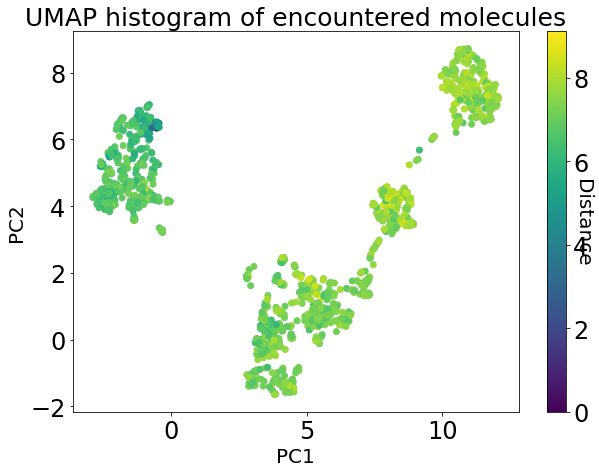

In [11]:

X_2d = ana.compute_UMAP(explored_rdkit)

#plot the pca
plt.figure(figsize=(10,7))
plt.scatter(X_2d[:,0], X_2d[:,1], c=distances_explored, cmap="viridis")

cbar = plt.colorbar()
cbar.set_label('Distance', rotation=270, fontsize=20)
plt.xlabel("PC1", fontsize=20)
plt.ylabel("PC2", fontsize=20)
plt.title("UMAP histogram of encountered molecules", fontsize=25)

Let us have a closer look at the 10 molecues closest to our inital molecule and the 10 molecules furthest away. We will use the RDKit to generate 2D representations of the molecules and plot them.

In [12]:
order_explored = np.argsort(distances_explored)

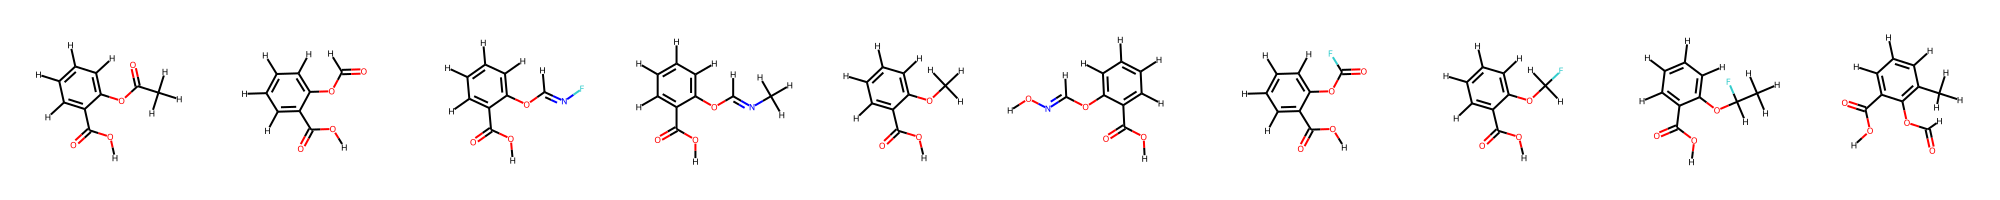

In [13]:
Draw.MolsToGridImage(explored_rdkit[order_explored][:10], molsPerRow=10)  

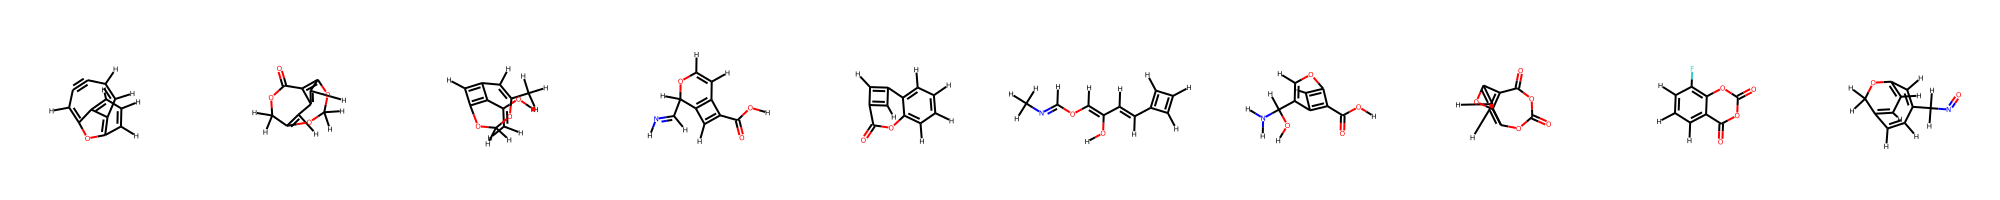

In [14]:
Draw.MolsToGridImage(explored_rdkit[order_explored[::-1]][:10], molsPerRow=10)  

In [15]:
aliens, dist_aliens = explored_smiles[order_explored], distances_explored[order_explored]
#write the aliens to a file
with open(f"aliens.txt", "w") as f:
    for alien,d in zip(aliens, dist_aliens):
        f.write(f"{alien},{d}\n")


In [16]:
explored_smiles_traj = np.array([ traj["SMILES"]  for traj in ALL_TRAJECTORIES[0]]).flatten()
explored_smiles_with_H_traj = [Chem.MolToSmiles(Chem.AddHs(Chem.MolFromSmiles(smi))) for smi in explored_smiles_traj] 
explored_rdkit_traj = np.array([Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in explored_smiles_with_H_traj])
explored_X_traj = rdkit_descriptors.get_all_FP(explored_rdkit_traj,fp_type="MorganFingerprint", nBits=nBits)

distances_explored_traj = np.array([norm(X_1 - X) for X in explored_X_traj])

Text(0.5, 1.0, 'UMAP trajectory of sampled molecules')

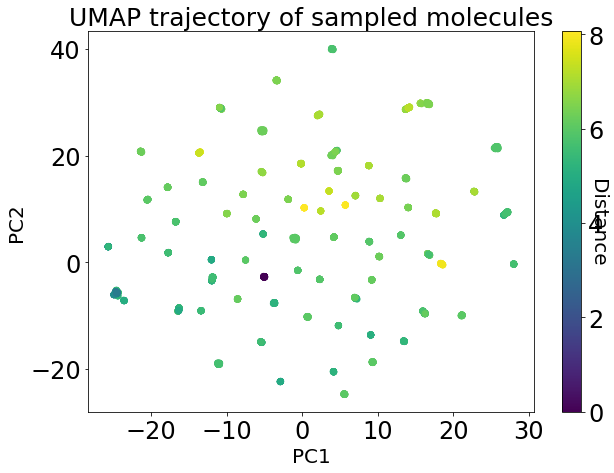

In [17]:
X_2d = ana.compute_UMAP(explored_rdkit_traj)

#plot the pca
plt.figure(figsize=(10,7))
plt.scatter(X_2d[:,0], X_2d[:,1], c=distances_explored_traj, cmap="viridis")

cbar = plt.colorbar()
cbar.set_label('Distance', rotation=270, fontsize=20)
plt.xlabel("PC1", fontsize=20)
plt.ylabel("PC2", fontsize=20)
plt.title("UMAP trajectory of sampled molecules", fontsize=25)

In [ ]:
%matplotlib inline
interctive_plot_show = False

if interctive_plot_show:

    from chemplot import Plotter
    from bokeh.io import output_notebook
        
    output_notebook()
    from bokeh.plotting import figure, output_file, save
    output_file(filename=f"umap.html", title="UMAP")
    import pandas as pd
    skip = 1

    #explored_smiles_traj, try without H

    df = pd.DataFrame({"smiles":explored_smiles_with_H_traj[::skip], "distances":distances_explored_traj[::skip]})
    cp = Plotter.from_smiles(df["smiles"], target = df["distances"], target_type="R")
    cp.umap(random_state=444)
    cp.cluster()
    cp.interactive_plot(show_plot=True,clusters=True)
    #save(cp)
    cp.interactive_plot(show_plot=True)

In [ ]:
compute_solvetion_energies = False

if compute_solvetion_energies:
    from bmapqml.chemxpl.minimized_functions.morfeus_quantity_estimates import (
        morfeus_FF_xTB_code_quants,
    )
    def compute_dG(SMILES):
        """
        Compute the dG of a molecule using Morfeus
        """
        
        solvent = "water"

        num_attempts = 16

        num_conformers = 32

        quantities = [
            "energy",
            "HOMO_LUMO_gap",
            "solvation_energy",
            "dipole",
            "num_evals",
        ]


        try:
            tp = TrajectoryPoint(egc=SMILES_to_egc(SMILES))
            res_dict = morfeus_FF_xTB_code_quants(
            tp,
            num_conformers=num_conformers,
            num_attempts=num_attempts,
            remaining_rho=0.9,
            quantities=quantities,
            solvent=solvent)

            dG = res_dict["mean"]["solvation_energy"]
            if isinstance(dG, type(None)):
                return np.nan 
            else:
                return  dG
        except:
            return np.nan 


    solvation_energies = []
    for mol in tqdm(aliens[:20]):
        dG  = compute_dG(mol)
        solvation_energies.append(dG)
    
    plt.hist(solvation_energies)



The results are saved in form of `pkl` files. We can load them and plot the results.